# Elife Paper 
When using these notebooks for the first time, make sure the `load` parameter is False and `save` parameter is True. This will simulate and save the class including its data locally. While running it next time, and all consecutive times, make sure 'load' parameter is True. This will load the saved class locally saving essential runtime. 
## Figure 2
1. Syrinx reward landscapes
2. Artificial reward landscapes 
3. Spectrograms of 4 syllables
### Reward Landscape Plots

In [1]:
load = True
save = False

In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import json 
import pickle
from functions import *
import queue
from scipy.integrate import solve_ivp
from env_lite import Environment
from model import NN

In [3]:
# load parameters from json file
params_path = "params_2.json"
# Open the file and read the contents
with open(params_path, "r") as f:
    parameters = json.load(f)

In [4]:
# running conditions
N_DAILY_MOTIFS = parameters['params']['TRIALS'] # trials per day per syllable  # old code TRIALS
TRIALS = N_DAILY_MOTIFS
BG_INTACT_DAYS = parameters['params']['BG_INTACT_DAYS']
DAYS = parameters['params']['DAYS'] # days for learning
N_SYLL = parameters['params']['N_SYLL'] # number of syllables   
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 40
ANNEALING = parameters['params']['ANNEALING'] # annealing 
print(ANNEALING)                  
print(f'Random seed is {RANDOM_SEED}')

1
Random seed is 40


In [5]:
# Config
# 1 to load model
# 1 to save model

model_version = "model_4_40"  # e.g., "model","model_1" "model20", "model_4_40", "model_syrinx_4_41"etc.

model_path = f"{model_version}.pkl"

if load:
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            obj = pickle.load(f)
            print(f"Model '{model_version}' loaded successfully!")
    else:
        raise FileNotFoundError(f"Model file '{model_path}' not found.")

else:
    obj = Environment(RANDOM_SEED, parameters, NN)
    obj.run(parameters, ANNEALING)

    if save:
        if os.path.exists(model_path):
            print(f"Model file '{model_path}' already exists. Not overwriting.")
        else:
            try:
                pickle.dumps(obj)  # Test serialization
                with open(model_path, "wb") as f:
                    pickle.dump(obj, f)
                print(f"Model '{model_version}' saved successfully.")
            except pickle.PicklingError:
                print("Object cannot be pickled!")


Model 'model_4_40' loaded successfully!


In [9]:
def plot_lansdcape(syll, force_landscape=False, landscape=1):
    fig, axs = plt.subplots(figsize=(10, 9))
    cmap = 'Purples' #LinearSegmentedColormap.from_list('white_to_black', ['white', 'rebeccapurple'])
    levels_ = 50
    def plot_artificial():
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward([X, Y], syll)
        contour = axs.contourf(X, Y, Z, levels=levels_, cmap=cmap)
        axs.contour(X, Y, Z, levels=10, colors='k', linewidths=1, alpha=0.9)
        cbar = fig.colorbar(contour, ax=axs)
        cbar.set_label('Performance Metric (R)', fontsize=20, rotation = 270)
        cbar.ax.tick_params(labelsize=18)
        cbar.ax.set_yticks([0,1])

        axs.set_xticks([-limit, 0, limit], [-1, 0, 1])
        axs.set_yticks([-limit, 0, limit], [-1, 0, 1])

    def plot_syrinx():
        if obj.N_SYLL > 4:
            raise ValueError('Only 4 syllables are available in the syrinx landscape')
        obj.syrinx_contours = []
        obj.syrinx_targets = []
        for j in range(obj.N_SYLL):
            base = np.load(f"contours/Syll{j+1}.npy")
            Z, target = make_contour(base)
            obj.syrinx_contours.append(Z)
            obj.syrinx_targets.append(target)
        obj.centers = np.array(obj.syrinx_targets)
        obj.syrinx_contours = np.array(obj.syrinx_contours)
        Z = obj.syrinx_contours[syll]
        target_pos = obj.syrinx_targets[syll]
        axs.contour(Z.T, levels=10, extent=[-1, 1, -1, 1], colors='k', linewidths=1, alpha=1)
        cs = axs.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1], levels=levels_)
        cbar = fig.colorbar(cs, ax = axs)
        cbar.set_label('Performance Metric (R)', fontsize=20, rotation = 270)
        cbar.ax.tick_params(labelsize=18)
        cbar.ax.set_yticks([0,1])
        axs.set_xticks([-1, 1], [0, 1])
        axs.set_yticks([-1,1], [0, 0.2])
        # axs.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')

    if not force_landscape:
        if obj.LANDSCAPE == 0:
            print("No force artificial landscape")
            plot_artificial()
        else:
            plot_syrinx()
    else:
        if landscape == 0:
            plot_artificial()
        else:
            plot_syrinx()

    # axs.set_ylabel(r'$P_{\alpha}$', fontsize=22)
    # axs.set_xlabel(r'$P_{\beta}$', fontsize=22)
    axs.set_ylabel(r'$P_{\alpha}$ (Pressure)', fontsize=22)
    axs.set_xlabel(r'$P_{\beta}$ (Tension)', fontsize=22)
    axs.tick_params(labelsize=16)
    axs.legend()
    plt.tight_layout()
    plt.show()



#### 1. Artificial landscapes

In [ ]:

for i in range(N_SYLL):
    plot_lansdcape(i, force_landscape=0, landscape= 1)


#### 2. Syrinx Landscapes

In [ ]:

for i in range(N_SYLL):
    plot_lansdcape(i, force_landscape=1, landscape= 1)      

#### 3. Spectrograms
Plots 4 spectrograms for 4 syllables

In [7]:
np.random.seed(100)
# Parameters
gamma = 12000 

duration = 0.050 #s
dt = 1/44100 #s  #* 0.1 #1.e-4

Amp = 10

# Trachea parameters
r=-0.9
v=350*100
L=1.9
tau_0=2*L/v # Propagation time along trachea
tau_n=int(tau_0/dt)
# ks = np.linspace(0.16,0.52, 10)
# ps = np.linspace(1852,2084, 10)

# Track position and velocity 
nt = int(duration/dt)
X = np.zeros(nt)          # Labial position
Y = np.zeros(nt)          # Velocity

def sigmoid(x):
      return 1 / (1 + np.exp(-x))

def syrinxODE(t, y):
    ''' ODEs used in Amador paper'''
    
    y0, y1 = y
    dydt = [y1,
         -Pressure(t)*(gamma**2) - Tension(t)*(gamma**2)*y0 - (gamma**2)*(y0**3) - gamma*(y0**2)*y1 + (gamma**2)*(y0**2) - gamma*y0*y1
           ]
    return dydt

# RC4
# syllable 1
syllable_array = [1,2,3,4]
P_t_list = []  # <— add before the syllable loop




for syllable in syllable_array:
    if syllable == 1:
        def Tension(t):
            """ Generalised exponential waveform """
            return   .3 - .2*np.exp(-200*t) -.00001 * np.exp(200*t) 

        
        def Pressure(t):
            """ Constant """
            return 0.04*np.sin((duration/2 + t)*np.pi*10) + 0.05
    # RC5 - test
    elif syllable == 2:
        # syllable 2
        def Tension(t):
            """ Generalised exponential waveform """
            Tc = 1#2/3
            return   .3 - .2*np.exp(-Tc*3*100*t) -.00001 * np.exp(Tc*3*100*t) 

        def Pressure(t):
            """ Constant """
            tp = 0.2
            return tp*np.sin((duration/2 + t)*np.pi*10) + 0.05
    elif syllable == 3:
        # syllable 3
        def Tension(t):
            """
                Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
                Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
                Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
            """
            scale = 1
            if isinstance(t, float):
                if t <= duration*scale/2: 
                    return 5*np.sin(t*np.pi*40/scale) + 0.6 # old amp 0.1
                elif t <= duration*scale: 
                    return 10*np.sin((t-duration*scale/2)*np.pi*15/scale) + 0.6 # old amp 0.2
                else: 
                    return 0.0 + 0*t
            elif isinstance(t, np.ndarray):
                Tension1 = 5*np.sin(t*np.pi*40/scale) + 0.6 # old amp 0.1
                Tension2 = 10*np.sin(t*np.pi*15/scale) + 0.6 # old amp 0.2
                Tension3 = 0.0 + 0*t
                return np.concatenate((Tension1[:int(np.ceil(t.size*scale/2))], Tension2[:int(t.size*scale-t.size*scale/2)], Tension3[:int(t.size-t.size*scale)]))        
        
        def Pressure(t):
            """ Pressure = 0.02 * np.ones((nt)) """
            return np.ones((np.asarray(t).shape)) * 2 # old amp 0.16
    elif syllable == 4:
        # syllable 4
        def Tension(t):
            """
                Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
                Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
                Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
            """
            scale = 0.4
            if isinstance(t, float):
                if t <= duration*scale: 
                    return 0.8*np.sin(t*np.pi*20/scale) + 0.6 # old amp 0.1
                else: 
                    return t*0 + 0.6 # old amp 0.2
            elif isinstance(t, np.ndarray):
                Tension1 = 0.8*np.sin(t*np.pi*20/scale) + 0.6 # old amp 0.1
                Tension2 = t* 0 + 0.6 # old amp 0.2
                return np.concatenate((Tension1[:int(np.ceil(t.size*scale))], Tension2[:int(t.size-t.size*scale)]))
            
        def Pressure(t):
            """ Pressure = 0.02 * np.ones((nt)) """
            return np.ones((np.asarray(t).shape)) * 0.01
            
    elif syllable == 5:
        # syllable 5
        def Tension(t):
            """ Tension = 0.2 * np.ones((nt)) """
            return np.ones((np.asarray(t).shape)) * 0.2
            
        def Pressure(t):
            """ Pressure = 0.1 * np.ones((nt)) """
            return np.ones((np.asarray(t).shape)) * 0.1
    elif syllable == 6:
        # syllable 6
        def Tension(t):
            """
                Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
                Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
                Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
            """
            if isinstance(t, float):
                if t <= duration/2: return 0.1*np.sin(t*np.pi*40) + 0.6
                else: return 0.2*np.sin((t-duration/2)*np.pi*15) + 0.6
            elif isinstance(t, np.ndarray):
                Tension1 = 0.1*np.sin(t*np.pi*40) + 0.6
                Tension2 = 0.2*np.sin(t*np.pi*15) + 0.6
                return np.concatenate((Tension1[:int(np.ceil(t.size/2))], Tension2[:int(t.size-t.size/2)]))
            
        def Pressure(t):
            """ Pressure = 0.01*np.sin(sin_t*np.pi*2*100) + 0.02 """
            return 0.01*np.sin(t*np.pi*2*100) + 0.02
        

    solution = solve_ivp(syrinxODE, [0, duration], [1, 1], method = "RK45", t_eval = np.linspace(0,duration,nt), rtol = 1e-8, atol = 1e-8)
    # Extract labial position (X) and velocity (Y)
    X = solution['y'][0]
    Y = solution['y'][1]
    # Transform into song
    time_x = np.linspace(0, duration, nt)
    song = Amp * Pressure(time_x) * Y
    ## Trachea from Darshan, et. al. https://doi.org/10.1038/ncomms15415

    # Input to trachea = output of syrinx
    y0 = song.T

    # To generate pressure output from trachea
    P_i=np.zeros((len(y0)))

    # See Fig 1 in Amador paper. Round-about way to implement that.
    Buffer = queue.Queue()
    for i in np.arange(tau_n):
        Buffer.put(np.random.random())

    for i in np.arange(len(y0)):
        P_i[i] = y0[i] - r*Buffer.get();      
        # update_buffer
        Buffer.put(P_i[i])

    # P_tr from P_in (ref Amador paper)
    BufferB=np.zeros((tau_n))
    P_tmp= np.concatenate((BufferB, P_i))
    P_t=(1-r)*P_tmp[:-tau_n]
    # ... inside your syllable loop, after computing P_t ...
    P_t_list.append(P_t.copy())
    time_x = np.linspace(0, duration, nt)




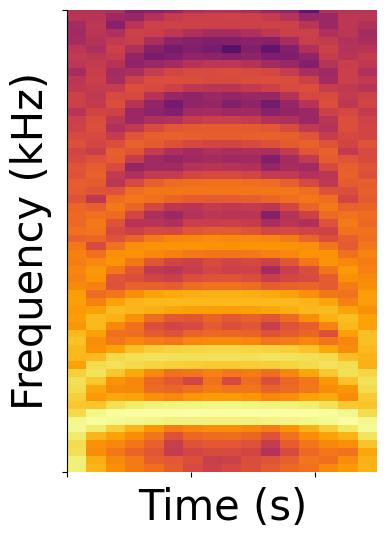

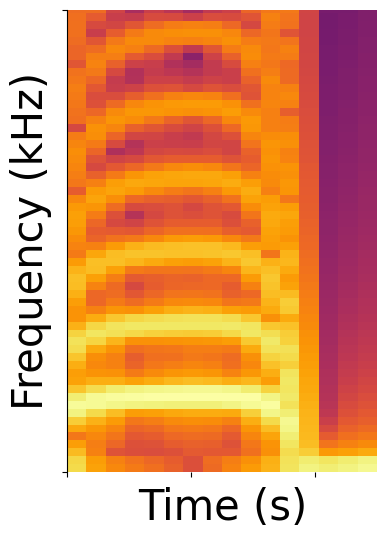

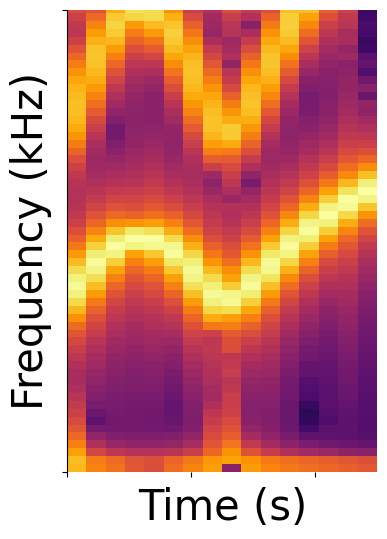

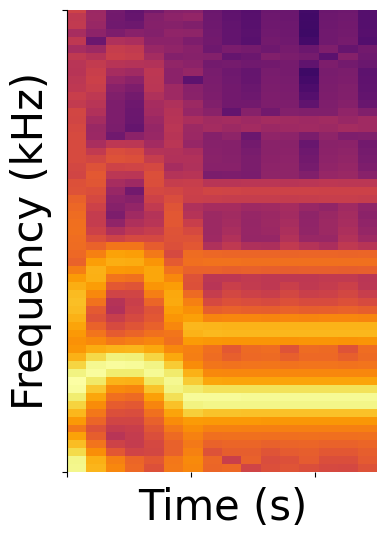

In [8]:
for i in range(4):
    P_t = P_t_list[i]
    figure, ax = plt.subplots(1)

    (spectrumP, freqsP, t, im) = plt.specgram(P_t, Fs=1/dt, NFFT=256, noverlap=128, xextent=[0,.05], cmap='inferno')
    im


    ax.set_ylabel('Frequency (kHz)', fontsize=30)
    ax.set_xlabel('Time (s)', fontsize=30)
    # ax.set_title(f'Syllable:{syllable}', fontsize=30)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylim(0,10000)
    ax.set_xlim(0,.05)
    ax.set_xticklabels([])
    ax.set_yticks([0, 10000])
    ax.set_yticklabels([0, 10])
    ax.set_yticklabels([])
    ax.tick_params(labelsize=15)

    figure.set_size_inches(4, 6, forward=True)


    plt.plot()
    plt.show()